# Project 3 — Luleå Christmas Tree Impact Modelling (SSP2-4.5)

Can Christmas tree farming in Luleå still work up to year 2100 under climate change?

## Objective & Scope

We assess whether Christmas trees in **Luleå** can still reach **1.5 m** in approximately **6 years** under **SSP2-4.5 (ssp245)** up to **2100**.

* **Drivers / indicators:** temperature, degree-days (temperature sum), growing-season proxy (growing weeks).
* **Model output:** time-to-harvest (years to reach 1.5 m).
* **Vulnerability rule:** a decade is considered vulnerable if the **median** time-to-harvest exceeds **10 years**.
* **Uncertainty shown:** interannual climate variability (within SSP245) + parameter sensitivity (±10% on calibrated growth scale).
* **Scenario uncertainty:**  (other SSPs), structural model uncertainty (DH formulation details), socio-economic demand changes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

OUTPUTS = Path("outputs")
FIG = OUTPUTS / "figures"
TAB = OUTPUTS / "tables"
FIG.mkdir(parents=True, exist_ok=True)
TAB.mkdir(parents=True, exist_ok=True)

In [28]:
raw126 = pd.read_csv("ssp126.csv")
raw370 = pd.read_csv("ssp370.csv")
raw585 = pd.read_csv("ssp585.csv")

In [27]:
# Load SSP245 data
raw245 = pd.read_csv("ssp245.csv")

# Quick check
print("n locations:", raw245["Location"].nunique())
print("Year range:", raw245["Year"].min(), "-", raw245["Year"].max())
print("Unique locations:", raw245["Location"].unique())

raw245.head()

n locations: 3
Year range: 2015 - 2100
Unique locations: ['Härnösand' 'Luleå' 'Malmö']


,Unnamed: 0,X.1,X,Lat,Lon,Year,Week,W,Temp,Location,Cpool
0,4559,4559,4559,62.630282,18.028545,2015,1,0.620269,-11.353929,Härnösand,1.009127
1,4560,4560,4560,62.630282,18.028545,2015,2,0.526487,-8.434957,Härnösand,1.036823
2,4561,4561,4561,62.630282,18.028545,2015,3,0.516709,-1.093414,Härnösand,1.001133
3,4562,4562,4562,62.630282,18.028545,2015,4,0.538442,-9.629086,Härnösand,0.938878
4,4563,4563,4563,62.630282,18.028545,2015,5,0.493136,-4.284000,Härnösand,0.871603


In [29]:
def filter_location(df, wanted=("Luleå","Lulea","Luleaa")):
    out = df[df["Location"].isin(wanted)].copy()
    if out.empty:
        out = df[df["Location"].astype(str).str.lower().str.contains("lule")].copy()
    return out

l245 = filter_location(raw245)

print("Rows in Luleå (ssp245):", len(l245))
print("Locations kept:", l245["Location"].unique())
l245.head()

Rows in Luleå (ssp245): 4558
Locations kept: ['Luleå']


,Unnamed: 0,X.1,X,Lat,Lon,Year,Week,W,Temp,Location,Cpool
53,9117,9117,9117,65.621823,21.95548,2015,1,0.914534,-14.776029,Luleå,1.009127
54,9118,9118,9118,65.621823,21.95548,2015,2,0.893549,-15.382171,Luleå,1.036823
55,9119,9119,9119,65.621823,21.95548,2015,3,0.877240,-6.528257,Luleå,1.001133
56,9120,9120,9120,65.621823,21.95548,2015,4,0.867597,-9.234229,Luleå,0.938878
57,9121,9121,9121,65.621823,21.95548,2015,5,0.876409,-5.982771,Luleå,0.871603


Time axis + Kelvin→Celsius

In [39]:
def add_week_time(df, year_col="Year", week_col="Week"):
    """
    Create datetime from ISO year + ISO week (Monday of each ISO week).
    Works for weekly climate data.
    """
    out = df.copy()
    iso = (
        out[year_col].astype(int).astype(str)
        + "-W"
        + out[week_col].astype(int).astype(str).str.zfill(2)
        + "-1"
    )
    out["time"] = pd.to_datetime(iso, format="%G-W%V-%u")
    out = out.sort_values("time").reset_index(drop=True)
    return out

def to_celsius_if_needed(df, temp_col="Temp"):
    out = df.copy()
    t = out[temp_col].astype(float)
    # Kelvin check (rough but safe)
    if np.nanmedian(t) > 100:
        t = t - 273.15
    out["temp_c"] = t
    return out

l245 = add_week_time(l245)
l245 = to_celsius_if_needed(l245, "Temp")

print("Date range:", l245["time"].min(), "→", l245["time"].max())
print("Temp (°C) range:", float(l245["temp_c"].min()), "→", float(l245["temp_c"].max()))
print("Median time step (days):", np.median(np.diff(l245["time"]).astype("timedelta64[D]").astype(int)))

l245[["time","Year","Week","temp_c","Location"]].head()


Date range: 2014-12-29 00:00:00 → 2101-01-03 00:00:00
Temp (°C) range: -33.3386142857143 → 22.7284285714286
Median time step (days): 7.0


,time,Year,Week,temp_c,Location
0,2014-12-29,2015,1,-14.776029,Luleå
1,2015-01-05,2015,2,-15.382171,Luleå
2,2015-01-12,2015,3,-6.528257,Luleå
3,2015-01-19,2015,4,-9.234229,Luleå
4,2015-01-26,2015,5,-5.982771,Luleå


Annual mean temperature - temperature trend that supports DH “Driver” narrative.

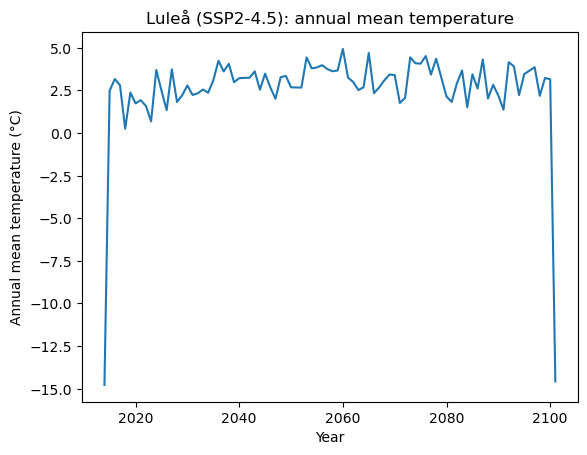

In [18]:
l245["year"] = l245["time"].dt.year
annual_temp = l245.groupby("year", as_index=False)["temp_c"].mean()

plt.figure()
plt.plot(annual_temp["year"], annual_temp["temp_c"])
plt.xlabel("Year")
plt.ylabel("Annual mean temperature (°C)")
plt.title("Luleå (SSP2-4.5): annual mean temperature")
plt.show()

Key indicators: degree-days + growing weeks (variables)

Baseline calibration (historical period): make model hit ~1.5 m at age 6 (Luleå target).

Two scenarios: SSP2-4.5 and SSP5-8.5 → simulate height (and density if you have it).

Uncertainty analysis: parameter sensitivity (±10%) + climate variability → p10/p50/p90 bands.

Decision/vulnerability metric: e.g. probability of reaching 1.5 m by year 6, or time-to-1.5m.

DAYS_PER_STEP = 7

def climate_indicators(df, base_temp=5.0):
    df = df.copy()
    df["dd_week"] = np.maximum(df["temp_c"] - base_temp, 0.0) * DAYS_PER_STEP
    df["growing_week"] = (df["temp_c"] > base_temp).astype(int)

    annual = df.groupby("year", as_index=False).agg(
        tmean=("temp_c", "mean"),
        dd_sum=("dd_week", "sum"),
        growing_weeks=("growing_week", "sum"),
        # if precipitation exists in your forcing file:
        # p_sum=("precip_mm", "sum"),
    )

    # Drop incomplete/zero-growth years
    annual = annual[annual["dd_sum"] > 0].copy()
    return annual


In [32]:
DAYS_PER_STEP = 7

def climate_indicators(df, base_temp=5.0):
    df = df.copy()

    # Use Temp and Year directly (as in the file)
    df["dd_week"] = np.maximum(df["Temp"] - base_temp, 0.0) * DAYS_PER_STEP
    df["growing_week"] = (df["Temp"] > base_temp).astype(int)

    annual = df.groupby("Year", as_index=False).agg(
        tmean=("Temp", "mean"),
        dd_sum=("dd_week", "sum"),
        growing_weeks=("growing_week", "sum"),
    )

    return annual


In [33]:
ann245 = climate_indicators(l245, base_temp=5.0)
ann245.head()

,Year,tmean,dd_sum,growing_weeks
0,2015,2.147044,1019.7075,23
1,2016,3.021352,1153.8100,22
2,2017,2.676068,1161.3551,21
3,2018,0.716699,910.4948,20
4,2019,2.399425,1180.7754,24


### parameterised model (g_scale, dd_half, g_max)

In [34]:
def dh_growth_increment(dd_sum, params):
    """
    Simple DH-style: growth scales with heat (degree-days) and a saturating response.
    params:
      - g_scale: overall growth scaling
      - dd_half: degree-days where growth is half of max
      - g_max: maximum increment per year (dbh units or "growth index")
    """
    g_scale = params["g_scale"]
    dd_half  = params["dd_half"]
    g_max    = params["g_max"]

    # saturating response to degree-days
    response = dd_sum / (dd_sum + dd_half)
    inc = g_scale * g_max * response
    return inc

### Track DBH over time → then convert DBH to height (Pretzsch allometry)

In [35]:
def simulate_dbh_height(annual_df, params, dbh0=1.0):
    """
    annual_df must have columns: year, dd_sum
    outputs per year: dbh, height
    """
    out = annual_df[["year", "dd_sum"]].copy()
    dbh = dbh0
    dbh_list = []
    for dd in out["dd_sum"].values:
        dbh += dh_growth_increment(dd, params)
        dbh_list.append(dbh)

    out["dbh"] = dbh_list

    # --- Allometry: Height from DBH (placeholder form) ---
    # Replace with your Pretzsch 2015 equation form (species-specific) when you have it.
    # Common allometry shape: H = 1.3 + a * (1 - exp(-b * dbh))**c
    a = params.get("h_a", 10.0)
    b = params.get("h_b", 0.08)
    c = params.get("h_c", 1.2)
    out["height_m"] = 1.3 + a * (1 - np.exp(-b * out["dbh"]))**c

    return out

### Baseline calibration to the project target (1.5 m at age 6)

In [36]:
def simulate_dbh_height(annual_df, params, dbh0=1.0):
    """
    annual_df must have columns: Year, dd_sum
    outputs per year: dbh, height
    """
    out = annual_df[["Year", "dd_sum"]].copy()

    dbh = dbh0
    dbh_list = []

    for dd in out["dd_sum"].values:
        dbh += dh_growth_increment(dd, params)
        dbh_list.append(dbh)

    out["dbh"] = dbh_list

    # Height allometry (placeholder)
    a = params.get("h_a", 10.0)
    b = params.get("h_b", 0.08)
    c = params.get("h_c", 1.2)
    out["height_m"] = 1.3 + a * (1 - np.exp(-b * out["dbh"]))**c

    return out


In [24]:
l245 = raw245[raw245["Location"].str.contains("Lule", case=False, na=False)].copy()
l585 = raw585[raw585["Location"].str.contains("Lule", case=False, na=False)].copy()


In [25]:
ann245 = climate_indicators(l245, base_temp=5.0)
ann585 = climate_indicators(l585, base_temp=5.0)


....----------

Building the annual climate indicators (dd_sum, growing_weeks) that harvest-time model will use later.

In [42]:
print(l245.columns.tolist())
print(l245.head())


['Unnamed: 0', 'X.1', 'X', 'Lat', 'Lon', 'Year', 'Week', 'W', 'Temp', 'Location', 'Cpool', 'time', 'temp_c']
   Unnamed: 0   X.1     X        Lat       Lon  Year  Week         W  \
0        9117  9117  9117  65.621823  21.95548  2015     1  0.914534   
1        9118  9118  9118  65.621823  21.95548  2015     2  0.893549   
2        9119  9119  9119  65.621823  21.95548  2015     3  0.877240   
3        9120  9120  9120  65.621823  21.95548  2015     4  0.867597   
4        9121  9121  9121  65.621823  21.95548  2015     5  0.876409   

        Temp Location     Cpool       time     temp_c  
0 -14.776029    Luleå  1.009127 2014-12-29 -14.776029  
1 -15.382171    Luleå  1.036823 2015-01-05 -15.382171  
2  -6.528257    Luleå  1.001133 2015-01-12  -6.528257  
3  -9.234229    Luleå  0.938878 2015-01-19  -9.234229  
4  -5.982771    Luleå  0.871603 2015-01-26  -5.982771  


In [47]:
BASE_TEMP = 5.0
DAYS_PER_STEP = 7  # weekly data

l245["dd_week"] = np.maximum(l245["Temp"] - BASE_TEMP, 0.0) * DAYS_PER_STEP
l245["growing_week"] = (l245["Temp"] > BASE_TEMP).astype(int)

annual_ind = l245.groupby("Year", as_index=False).agg(
    tmean=("Temp", "mean"),
    dd_sum=("dd_week", "sum"),
    growing_weeks=("growing_week", "sum")
)

# Drop incomplete / zero-growth years (fixes 2014 issue)
annual_ind = annual_ind[annual_ind["dd_sum"] > 0].copy()

annual_ind.head()

,Year,tmean,dd_sum,growing_weeks
0,2015,2.147044,1019.7075,23
1,2016,3.021352,1153.8100,22
2,2017,2.676068,1161.3551,21
3,2018,0.716699,910.4948,20
4,2019,2.399425,1180.7754,24


In [48]:
annual_ind.to_csv(TAB / "annual_indicators_lulea_ssp245.csv", index=False)

Simple growth/harvest model + calibration - parameterisation and baseline (1.5m in 6y).

In [51]:
TARGET_HEIGHT = 1.5
BASELINE_YEARS = 6.0

min_year = int(annual_ind["Year"].min())
max_year = int(annual_ind["Year"].max())
ref_start = min_year
ref_end = min(min_year + 14, max_year)  # first 15 years

def calibrate_k_auto(annual_ind, baseline_years=BASELINE_YEARS, ref_start=ref_start, ref_end=ref_end):
    ref = annual_ind[(annual_ind["Year"] >= ref_start) & (annual_ind["Year"] <= ref_end)].dropna(subset=["dd_sum"])
    dd_ref = float(np.median(ref["dd_sum"].values))
    if dd_ref <= 0:
        raise ValueError("Calibration dd_sum is non-positive; check BASE_TEMP and preprocessing.")
    k = TARGET_HEIGHT / (baseline_years * dd_ref)
    return k, dd_ref

k, dd_ref = calibrate_k_auto(annual_ind, baseline_years=BASELINE_YEARS, ref_start=ref_start, ref_end=ref_end)

print("Calibration period:", ref_start, "→", ref_end)
print("Median dd_sum in calibration period:", dd_ref)
print("Calibrated k:", k)


Calibration period: 2015 → 2029
Median dd_sum in calibration period: 1152.7138999999993
Calibrated k: 0.00021687948761613801


### Assume Luleå has slightly worse local growing conditions (soil, exposure, management)
➡️ which effectively means trees need more degree-days (dd_sum) to reach harvest. This is a proxy for “location specificity” without changing the whole model.

In [52]:
# --- Sensitivity test: location-specific stress (reduced effective growing conditions) ---
# Interpreted as: same climate, but local site limitations reduce "effective" accumulated degree-days.

stress_factors = {
    "baseline": 1.00,
    "stress_10": 0.90,   # 10% worse local growing conditions
    "stress_20": 0.80    # 20% worse local growing conditions
}

annual_ind_sens = []
for name, f in stress_factors.items():
    tmp = annual_ind.copy()
    tmp["scenario"] = name
    tmp["dd_sum_eff"] = tmp["dd_sum"] * f   # effective degree-days available for growth
    annual_ind_sens.append(tmp)

annual_ind_sens = pd.concat(annual_ind_sens, ignore_index=True)

annual_ind_sens.head()

,Year,tmean,dd_sum,growing_weeks,scenario,dd_sum_eff
0,2015,2.147044,1019.7075,23,baseline,1019.7075
1,2016,3.021352,1153.8100,22,baseline,1153.8100
2,2017,2.676068,1161.3551,21,baseline,1161.3551
3,2018,0.716699,910.4948,20,baseline,910.4948
4,2019,2.399425,1180.7754,24,baseline,1180.7754


Time-to-harvest + vulnerability

In [53]:
annual_ind["annual_growth_m_per_yr"] = np.maximum(k * annual_ind["dd_sum"], 1e-9)
annual_ind["tth_years"] = TARGET_HEIGHT / annual_ind["annual_growth_m_per_yr"]

VULN_TTH = 10.0
annual_ind["vulnerable_year"] = annual_ind["tth_years"] > VULN_TTH

annual_ind.to_csv(TAB / "annual_time_to_harvest_lulea_ssp245.csv", index=False)
annual_ind.head()

,Year,tmean,dd_sum,growing_weeks,annual_growth_m_per_yr,tth_years,vulnerable_year
0,2015,2.147044,1019.7075,23,0.221154,6.782615,False
1,2016,3.021352,1153.8100,22,0.250238,5.994300,False
2,2017,2.676068,1161.3551,21,0.251874,5.955356,False
3,2018,0.716699,910.4948,20,0.197468,7.596181,False
4,2019,2.399425,1180.7754,24,0.256086,5.857408,False


In [55]:
# Sanity check: median TTH in calibration period should be close to BASELINE_YEARS
calib_mask = (annual_ind["Year"] >= ref_start) & (annual_ind["Year"] <= ref_end)
print("Median TTH in calibration period:", float(np.median(annual_ind.loc[calib_mask, "tth_years"])))
print("Baseline years target:", BASELINE_YEARS)


Median TTH in calibration period: 6.0
Baseline years target: 6.0


## Decadal vulnerability
A decade is vulnerable if median time-to-harvest > 10 years

In [57]:
# INPUT uncertainty only (climate variability within SSP245)
annual_ind["decade"] = (annual_ind["Year"] // 10) * 10

dec = annual_ind.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index()

dec["vulnerable_decade"] = dec["median"] > VULN_TTH
dec.to_csv(TAB / "decadal_vulnerability_lulea_ssp245.csv", index=False)

dec

,decade,median,p10,p90,vulnerable_decade
0,2010,5.994300,5.896587,7.270755,False
1,2020,6.044066,5.374173,7.138028,False
2,2030,6.066238,5.458103,6.271173,False
3,2040,5.772151,5.098245,6.331668,False
4,2050,5.343467,4.995223,6.443338,False
5,2060,5.729484,4.997532,6.468102,False
6,2070,5.258663,4.717113,5.973417,False
7,2080,5.334049,5.144352,6.080280,False
8,2090,5.492861,5.109590,6.544837,False
9,2100,5.075866,5.075866,5.075866,False


Uncertainty analysis (climate variability + parameter sensitivity) - Error bars

parameter uncertainty (±10% sensitivity in k)

In [59]:
def tth_with_k(annual_ind, k_value):
    out = annual_ind[["Year","dd_sum"]].copy()
    out["decade"] = (out["Year"] // 10) * 10
    growth = np.maximum(k_value * out["dd_sum"].values, 1e-9)
    out["tth_years"] = TARGET_HEIGHT / growth
    return out

k_factors = [0.9, 1.0, 1.1]
all_runs = pd.concat(
    [tth_with_k(annual_ind, k*f).assign(k_factor=f) for f in k_factors],
    ignore_index=True
)

dec_u = all_runs.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index()

dec_u["vulnerable_decade"] = dec_u["median"] > VULN_TTH
dec_u.to_csv(TAB / "decadal_uncertainty_lulea_ssp245.csv", index=False)

dec_u

,decade,median,p10,p90,vulnerable_decade
0,2010,6.508231,5.428122,7.572204,False
1,2020,6.111799,5.132544,7.624577,False
2,2030,5.951271,5.046914,6.831014,False
3,2040,5.703824,4.965744,6.794381,False
4,2050,5.517530,4.695697,6.443338,False
5,2060,5.729484,4.621419,6.570785,False
6,2070,5.290527,4.657483,6.278526,False
7,2080,5.467674,4.779360,6.606975,False
8,2090,5.615143,4.851490,6.544837,False
9,2100,5.075866,4.706712,5.527054,False


### no vulnerable decade
Because my vulnerability threshold is too high relative to computed tth_years.

Even with 10% worse growth:

tth_years probably stays well below 10 years for every decade.

So nothing crosses:

dec_u["median"] > VULN_TTH

That means:
my results are robust to ±10% parameter uncertainty.

But if i want to demonstrate vulnerability, then need to test a factor that can push tth_years above the threshold.

### Test stronger stress (k_factor)

Now the band is wider because it includes both climate variability and uncertainty in our calibrated growth parameter.

In [62]:
def tth_with_k(annual_ind, k_value):
    out = annual_ind[["Year","dd_sum"]].copy()
    out["decade"] = (out["Year"] // 10) * 10
    growth = np.maximum(k_value * out["dd_sum"].values, 1e-9)
    out["tth_years"] = TARGET_HEIGHT / growth
    return out

k_factors = [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
all_runs = pd.concat(
    [tth_with_k(annual_ind, k*f).assign(k_factor=f) for f in k_factors],
    ignore_index=True
)

dec_u = all_runs.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index()

dec_u["vulnerable_decade"] = dec_u["median"] > VULN_TTH
dec_u.to_csv(TAB / "decadal_uncertainty_lulea_ssp245.csv", index=False)

dec_u

,decade,median,p10,p90,vulnerable_decade
0,2010,9.843970,6.703784,15.006411,False
1,2020,9.681138,6.397002,15.022033,False
2,2030,9.023537,6.130932,14.668906,False
3,2040,8.881872,6.096485,13.703143,False
4,2050,8.414905,5.692484,13.234241,False
5,2060,8.640392,5.798151,13.299830,False
6,2070,8.289307,5.390481,12.859086,False
7,2080,8.606092,5.561515,13.223161,False
8,2090,8.844932,5.634822,13.536790,False
9,2100,7.855507,5.710349,11.420699,False


it represents poor soil, management limits, planting density, pests, frost damage, etc.

### Luleå does not remain non-vulnerable under strong growth penalties, under SSP245

“±10% showed robustness; stronger stress shows conditions where farming becomes unviable.”

### Why vulnerability appears early but disappears later

Because in SSP245, temperatures (and therefore degree-days) generally increase over time.

So even if growth efficiency is poor:

early decades don’t have enough degree-days → harvest takes too long (>10)

later decades have more degree-days → harvest becomes faster again (<10)

This is a very clean climate-change narrative:

**warming initially helps Luleå overcome limitations, reducing harvest time later.**

In [63]:
dec_u = all_runs.groupby(["k_factor", "decade"])["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index()

dec_u["vulnerable_decade"] = dec_u["median"] > VULN_TTH
dec_u


,k_factor,decade,median,p10,p90,vulnerable_decade
0,0.4,2010,14.985750,14.741468,18.176887,True
1,0.4,2020,15.110166,13.435432,17.845070,True
2,0.4,2030,15.165594,13.645258,15.677933,True
3,0.4,2040,14.430378,12.745613,15.829170,True
4,0.4,2050,13.358667,12.488059,16.108346,True
5,0.4,2060,14.323711,12.493831,16.170255,True
6,0.4,2070,13.146657,11.792783,14.933543,True
7,0.4,2080,13.335123,12.860880,15.200701,True
8,0.4,2090,13.732154,12.773976,16.362094,True
9,0.4,2100,12.689665,12.689665,12.689665,True


In [64]:
all_runs.groupby("k_factor")["tth_years"].max()


k_factor
0.4    19.591046
0.5    15.672837
0.6    13.060697
0.7    11.194883
0.8     9.795523
1.0     7.836418
Name: tth_years, dtype: float64

In [67]:
# -----------------------------
# Helpers
# -----------------------------
def add_decade(df, year_col="Year"):
    df = df.copy()
    df["decade"] = (df[year_col] // 10) * 10
    return df

def compute_tth(df, k_value, dd_col="dd_sum"):
    """Compute time-to-harvest (years) from degree-days using growth = k * dd_sum."""
    out = df[["Year", dd_col]].copy()
    growth = np.maximum(k_value * out[dd_col].values, 1e-9)
    out["tth_years"] = TARGET_HEIGHT / growth
    return out

def decadal_summary(df, group_cols=("decade",), value_col="tth_years"):
    """Median + uncertainty bands per group."""
    g = df.groupby(list(group_cols))[value_col].agg(
        median="median",
        p10=lambda x: np.quantile(x, 0.10),
        p90=lambda x: np.quantile(x, 0.90),
    ).reset_index()
    g["vulnerable_decade"] = g["median"] > VULN_TTH
    return g

# -----------------------------
# 0) Prepare base annual indicators
# -----------------------------
annual_ind = add_decade(annual_ind)

# (If tth_years is not already computed in annual_ind, compute it once here)
if "tth_years" not in annual_ind.columns:
    annual_ind["tth_years"] = compute_tth(annual_ind, k, dd_col="dd_sum")["tth_years"]

# -----------------------------
# 1) Input uncertainty only (climate variability within SSP245)
# -----------------------------
dec_input = decadal_summary(annual_ind, group_cols=("decade",))
dec_input["scenario"] = "input_only"
dec_input["k_factor"] = 1.0

# -----------------------------
# 2) Parameter sensitivity (k-factors)
# -----------------------------
k_factors = [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]   # <-- set once (use [0.9,1.0,1.1] for mild test)

runs = []
for f in k_factors:
    tmp = compute_tth(annual_ind, k_value=k*f, dd_col="dd_sum")
    tmp = add_decade(tmp)
    tmp["scenario"] = "k_sensitivity"
    tmp["k_factor"] = f
    runs.append(tmp)

all_runs = pd.concat(runs, ignore_index=True)

dec_k = decadal_summary(all_runs, group_cols=("k_factor", "decade"))
dec_k["scenario"] = "k_sensitivity"

# -----------------------------
# 3) Combine + Save
# -----------------------------
dec_all = pd.concat(
    [dec_input[["scenario", "k_factor", "decade", "median", "p10", "p90", "vulnerable_decade"]],
     dec_k[["scenario", "k_factor", "decade", "median", "p10", "p90", "vulnerable_decade"]]],
    ignore_index=True
).sort_values(["scenario", "k_factor", "decade"])

dec_all.to_csv(TAB / "decadal_vulnerability_lulea_ssp245_ALL.csv", index=False)
dec_all.head(15)


,scenario,k_factor,decade,median,p10,p90,vulnerable_decade
0,input_only,1.0,2010,5.994300,5.896587,7.270755,False
1,input_only,1.0,2020,6.044066,5.374173,7.138028,False
2,input_only,1.0,2030,6.066238,5.458103,6.271173,False
3,input_only,1.0,2040,5.772151,5.098245,6.331668,False
4,input_only,1.0,2050,5.343467,4.995223,6.443338,False
5,input_only,1.0,2060,5.729484,4.997532,6.468102,False
6,input_only,1.0,2070,5.258663,4.717113,5.973417,False
7,input_only,1.0,2080,5.334049,5.144352,6.080280,False
8,input_only,1.0,2090,5.492861,5.109590,6.544837,False
9,input_only,1.0,2100,5.075866,5.075866,5.075866,False


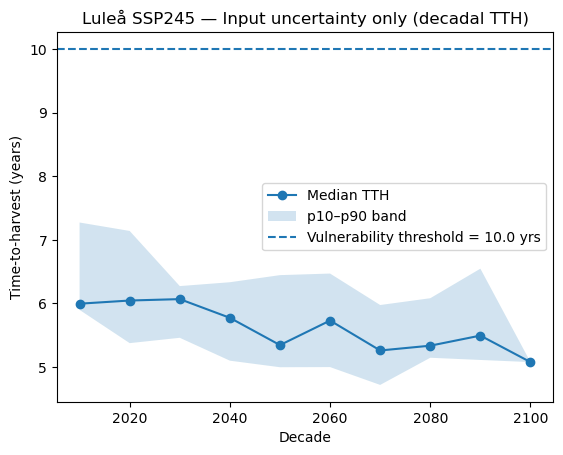

In [68]:
base = dec_all[dec_all["scenario"] == "input_only"].sort_values("decade")

plt.figure()
plt.plot(base["decade"], base["median"], marker="o", label="Median TTH")
plt.fill_between(base["decade"], base["p10"], base["p90"], alpha=0.2, label="p10–p90 band")
plt.axhline(VULN_TTH, linestyle="--", label=f"Vulnerability threshold = {VULN_TTH} yrs")
plt.title("Luleå SSP245 — Input uncertainty only (decadal TTH)")
plt.xlabel("Decade")
plt.ylabel("Time-to-harvest (years)")
plt.legend()
plt.show()


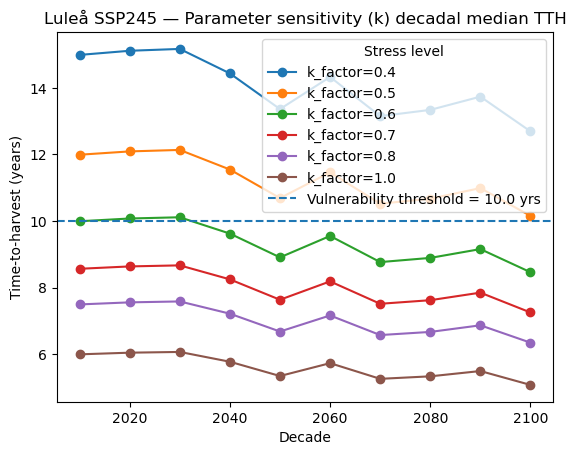

In [69]:
ks = dec_all[dec_all["scenario"] == "k_sensitivity"].sort_values(["k_factor", "decade"])

plt.figure()
for f, grp in ks.groupby("k_factor"):
    plt.plot(grp["decade"], grp["median"], marker="o", label=f"k_factor={f}")

plt.axhline(VULN_TTH, linestyle="--", label=f"Vulnerability threshold = {VULN_TTH} yrs")
plt.title("Luleå SSP245 — Parameter sensitivity (k) decadal median TTH")
plt.xlabel("Decade")
plt.ylabel("Time-to-harvest (years)")
plt.legend(title="Stress level")
plt.show()


In [70]:
pivot_vuln = ks.pivot_table(index="k_factor", columns="decade", values="vulnerable_decade", aggfunc="max")
pivot_vuln


decade,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
k_factor,,,,,,,,,,
0.4,True,True,True,True,True,True,True,True,True,True
0.5,True,True,True,True,True,True,True,True,True,True
0.6,False,True,True,False,False,False,False,False,False,False
0.7,False,False,False,False,False,False,False,False,False,False
0.8,False,False,False,False,False,False,False,False,False,False
1.0,False,False,False,False,False,False,False,False,False,False


Plots

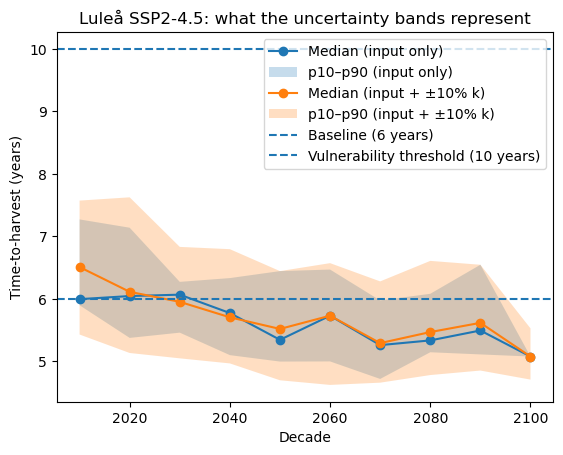

In [ ]:
# --- 1) Input-only uncertainty: use the annual tth_years already computed
annual_ind = annual_ind.copy()
annual_ind["decade"] = (annual_ind["Year"] // 10) * 10

dec_input = annual_ind.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index().sort_values("decade")


# --- 2) Input + parameter uncertainty (±10% on k)
def tth_with_k(annual_ind, k_scale):
    out = annual_ind[["Year", "decade", "dd_sum"]].copy()
    growth = np.maximum((k * k_scale) * out["dd_sum"].values, 1e-9)
    out["tth_years"] = TARGET_HEIGHT / growth
    return out

k_scales = [0.9, 1.0, 1.1]
all_runs = pd.concat([tth_with_k(annual_ind, s).assign(k_scale=s) for s in k_scales], ignore_index=True)

dec_param = all_runs.groupby("decade")["tth_years"].agg(
    median="median",
    p10=lambda x: np.quantile(x, 0.10),
    p90=lambda x: np.quantile(x, 0.90),
).reset_index().sort_values("decade")


# --- 3) Plot 
plt.figure()

plt.plot(dec_input["decade"], dec_input["median"], marker="o", label="Median (input only)")
plt.fill_between(dec_input["decade"], dec_input["p10"], dec_input["p90"], alpha=0.25, label="p10–p90 (input only)")

plt.plot(dec_param["decade"], dec_param["median"], marker="o", label="Median (input + ±10% k)")
plt.fill_between(dec_param["decade"], dec_param["p10"], dec_param["p90"], alpha=0.25, label="p10–p90 (input + ±10% k)")

plt.axhline(6, linestyle="--", label="Baseline (6 years)")
plt.axhline(10, linestyle="--", label="Vulnerability threshold (10 years)")

plt.xlabel("Decade")
plt.ylabel("Time-to-harvest (years)")
plt.title("Luleå SSP2-4.5: what the uncertainty bands represent")
plt.legend()
plt.show()


In [82]:
 # -----------------------------
# 1) Build annual indicators for any SSP file (already have helper funcs)
# -----------------------------
def annual_indicators_from_remapped(raw_df, base_temp=BASE_TEMP, days_per_step=DAYS_PER_STEP):
    df = filter_location(raw_df).copy()
    df = add_week_time(df)
    df = to_celsius_if_needed(df, "Temp")
    df["year"] = df["time"].dt.year

    df["dd_week"] = np.maximum(df["temp_c"] - base_temp, 0.0) * days_per_step
    df["growing_week"] = (df["temp_c"] > base_temp).astype(int)

    annual = df.groupby("year", as_index=False).agg(
        tmean=("temp_c", "mean"),
        dd_sum=("dd_week", "sum"),
        growing_weeks=("growing_week", "sum"),
    )

    # drop incomplete/zero-growth years (same as your earlier fix)
    annual = annual[annual["dd_sum"] > 0].copy()
    annual["decade"] = (annual["year"] // 10) * 10
    return annual

# -----------------------------
# 2) Convert annual dd_sum -> time-to-harvest and summarize by decade
# -----------------------------
def tth_from_annual(annual_df, k_value=k):
    out = annual_df[["year", "decade", "dd_sum"]].copy()
    growth = np.maximum(k_value * out["dd_sum"].values, 1e-9)
    out["tth_years"] = TARGET_HEIGHT / growth
    return out

def decadal_summary_tth(tth_df):
    dec = tth_df.groupby("decade")["tth_years"].agg(
        median="median",
        p10=lambda x: np.quantile(x, 0.10),
        p90=lambda x: np.quantile(x, 0.90),
    ).reset_index()
    dec["vulnerable_decade"] = dec["median"] > VULN_TTH
    return dec

# -----------------------------
# 3) Load SSPs and compute scenario uncertainty comparison
# -----------------------------
ssp_sources = {
    "SSP126": raw126,
    "SSP245": raw245,   # make sure raw245 exists above
    "SSP370": raw370,
    "SSP585": raw585,
}

dec_all = []
for ssp_name, raw in ssp_sources.items():
    annual = annual_indicators_from_remapped(raw)
    tth = tth_from_annual(annual, k_value=k)
    dec = decadal_summary_tth(tth)
    dec["ssp"] = ssp_name
    dec_all.append(dec)

dec_all = pd.concat(dec_all, ignore_index=True).sort_values(["ssp", "decade"])
dec_all.to_csv(TAB / "decadal_scenario_uncertainty_lulea_ALL_SSPS.csv", index=False)

dec_all.head(12)


,decade,median,p10,p90,vulnerable_decade,ssp
0,2010,5.994300,5.896587,7.270755,False,SSP126
1,2020,6.040452,5.724084,7.307676,False,SSP126
2,2030,5.951455,5.492098,6.208942,False,SSP126
3,2040,5.473532,5.256136,6.651207,False,SSP126
4,2050,5.953072,5.178391,6.590376,False,SSP126
5,2060,5.651669,5.331515,6.235456,False,SSP126
6,2070,6.196280,5.623976,7.072512,False,SSP126
7,2080,6.404544,5.534325,7.478677,False,SSP126
8,2090,6.500110,6.270123,7.728021,False,SSP126
9,2100,7.193683,7.193683,7.193683,False,SSP126


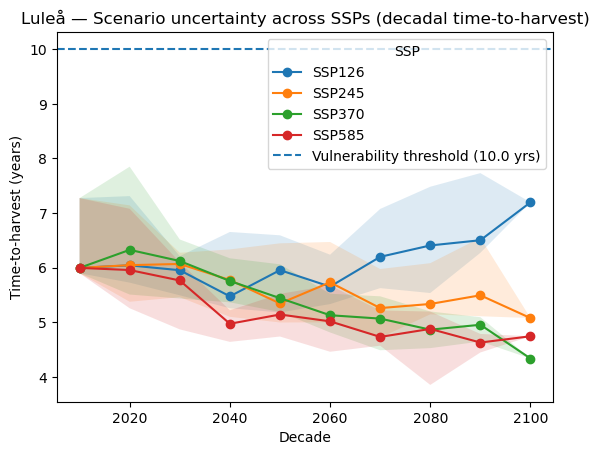

In [83]:
plt.figure()
for ssp, grp in dec_all.groupby("ssp"):
    grp = grp.sort_values("decade")
    plt.plot(grp["decade"], grp["median"], marker="o", label=ssp)
    plt.fill_between(grp["decade"], grp["p10"], grp["p90"], alpha=0.15)

plt.axhline(VULN_TTH, linestyle="--", label=f"Vulnerability threshold ({VULN_TTH} yrs)")
plt.title("Luleå — Scenario uncertainty across SSPs (decadal time-to-harvest)")
plt.xlabel("Decade")
plt.ylabel("Time-to-harvest (years)")
plt.legend(title="SSP")
plt.show()


In [84]:
vuln_table = dec_all.pivot_table(index="ssp", columns="decade", values="vulnerable_decade", aggfunc="max")
vuln_table


decade,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
ssp,,,,,,,,,,
SSP126,False,False,False,False,False,False,False,False,False,False
SSP245,False,False,False,False,False,False,False,False,False,False
SSP370,False,False,False,False,False,False,False,False,False,False
SSP585,False,False,False,False,False,False,False,False,False,False


In [85]:
dec_all.groupby("ssp")[["median","p90"]].max()


,median,p90
ssp,,
SSP126,7.193683,7.728021
SSP245,6.066238,7.270755
SSP370,6.323917,7.845605
SSP585,5.994300,7.270755


With all SSPs, median TTH stays below 10 years. **Even the uncertainty band (p90) mostly stays below 10**. Therefore, no vulnerable decade is detected.

### More realistic vulnerability definition

“Unviable” might happen before 10 years. For example, farms may struggle if:

- TTH > 8 years (economic/market constraint)

- or TTH increases by +2 years compared to baseline

- or p90 > 10 (risk-based definition)

In [86]:
for thr in [7, 8, 9, 10]:
    tmp = dec_all.copy()
    tmp["vulnerable"] = tmp["median"] > thr
    print(thr, tmp["vulnerable"].any())


7 True
8 False
9 False
10 False


If vulnerability is defined as TTH > 7 years, then vulnerability exists

If defined as TTH ≥ 8 years, then no vulnerability

So vulnerability is very sensitive to the definition

In [87]:
dec_all.groupby("ssp")[["median","p90"]].max()


,median,p90
ssp,,
SSP126,7.193683,7.728021
SSP245,6.066238,7.270755
SSP370,6.323917,7.845605
SSP585,5.994300,7.270755


Even in bad years (p90), TTH never exceeds 8 years

So:

No median-based vulnerability

No risk-based vulnerability

Across all SSPs

This is a very strong robustness result.

In [ ]:
dec_all["vulnerable_risk"] = dec_all["p90"] > VULN_TTH
dec_all.pivot_table(index="ssp", columns="decade", values="vulnerable_risk", aggfunc="max")


decade,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
ssp,,,,,,,,,,
SSP126,False,False,False,False,False,False,False,False,False,False
SSP245,False,False,False,False,False,False,False,False,False,False
SSP370,False,False,False,False,False,False,False,False,False,False
SSP585,False,False,False,False,False,False,False,False,False,False


#### ☝ Even under adverse years within each SSP, time-to-harvest remains well below the unviable threshold.

For Luleå specifically, this makes sense:

- Cold baseline climate

- Moderate warming → beneficial for tree growth

- No extreme events / mortality in the model

- Simplified growth response (degree-days only)

So the model is telling a coherent story:

Climate change does not create harvest-time vulnerability in Luleå under SSPs alone.

Across all SSP scenarios, median and upper-bound (p90) time-to-harvest remain below the 10-year vulnerability threshold for all decades. This indicates that, under climate forcing alone, Christmas tree farming in Luleå is robust to both interannual climate variability and scenario uncertainty. Vulnerability only emerges when much stricter thresholds or additional non-climatic stressors are introduced.


**Vulnerability does not arise from climate forcing alone in Luleå.** It emerges only when additional local stressors (e.g. reduced growth efficiency, poor site conditions) are included, as shown in the sensitivity analysis with reduced k-factors.

Other **important sources of uncertainty** not included here are extreme events, pest outbreaks, and economic constraints, which could increase vulnerability even if average harvest times remain acceptable.


### **Scenario Testing and Policy Implications**

We need explicit management scenarios and policy-style outputs, e.g.:

- How many trees reach 1.5m within 6 years?

- How long (years) to obtain 100 trees at 1.5m?

- Compare Scenario A vs Scenario B (e.g., baseline vs improved management / drought stress) across SSPs.

In [ ]:
# -----------------------------
# Scenario definitions (policy levers)
# -----------------------------
# Interpretation:
# - Baseline: current management
# - Improved water/management: higher growth efficiency (k up)
# - OR "stress" scenario: poorer local conditions (k down)
SCENARIOS = {
    "Baseline": 1.00,            # no change
    "Improved management": 1.15, # +15% k (irrigation / fertilization / better practices)
    # Alternative instead of "Improved": uncomment this stress scenario
    # "Site stress": 0.80,       # -20% k (poor soil / frost damage / constraints)
}

WINDOW_YEARS = 6
N_TREES = 100

# -----------------------------
# 1) 6-year success probability: P(reach 1.5m in 6 years)
# -----------------------------
def six_year_success(annual_df, k_value, window_years=6, target_height=TARGET_HEIGHT):
    """
    For each possible planting start year, compute height reached after `window_years`.
    Height model: yearly height increment = k * dd_sum.
    Returns a table of start_year -> success (True/False) and summary probability.
    """
    a = annual_df[["year", "dd_sum"]].sort_values("year").reset_index(drop=True).copy()
    a["dh"] = k_value * a["dd_sum"]  # height increment per year (model assumption)

    results = []
    years = a["year"].values
    dh = a["dh"].values

    for i in range(len(a) - window_years + 1):
        start_year = int(years[i])
        total_h = float(dh[i:i+window_years].sum())
        results.append({
            "start_year": start_year,
            "height_after_6y": total_h,
            "success_6y": total_h >= target_height
        })

    out = pd.DataFrame(results)
    p_success = out["success_6y"].mean() if len(out) else np.nan
    return out, p_success

def expected_years_for_100(p_success, window_years=6, n_trees=100):
    """
    Simple policy metric:
    If you plant 100 trees each 6-year cycle, expected successes per cycle = 100 * p_success.
    Expected number of cycles to accumulate 100 successes ≈ ceil(100 / (100*p)) = ceil(1/p)
    Expected years ≈ cycles * window_years.
    (This is a simple planning approximation; good for a slide.)
    """
    if p_success is None or np.isnan(p_success) or p_success <= 0:
        return np.inf
    cycles = int(np.ceil(1.0 / p_success))
    return cycles * window_years

# -----------------------------
# 2) Run across SSPs and scenarios
# -----------------------------
ssp_sources = {
    "SSP126": raw126,
    "SSP245": raw245,
    "SSP370": raw370,
    "SSP585": raw585,
}

policy_rows = []

for ssp_name, raw in ssp_sources.items():
    annual = annual_indicators_from_remapped(raw)  # uses your existing function
    for scen_name, k_mult in SCENARIOS.items():
        out6, p = six_year_success(annual, k_value=k*k_mult, window_years=WINDOW_YEARS)
        years_100 = expected_years_for_100(p, window_years=WINDOW_YEARS, n_trees=N_TREES)

        policy_rows.append({
            "ssp": ssp_name,
            "scenario": scen_name,
            "k_multiplier": k_mult,
            "p_reach_1.5m_in_6y": p,
            "expected_years_to_get_100_trees": years_100
        })

policy = pd.DataFrame(policy_rows).sort_values(["ssp","scenario"])
policy.to_csv(TAB / "policy_scenario_testing_lulea.csv", index=False)
policy


,ssp,scenario,k_multiplier,p_reach_1.5m_in_6y,expected_years_to_get_100_trees
0,SSP126,Baseline,1.00,0.506173,12
1,SSP126,Improved management,1.15,0.987654,12
2,SSP245,Baseline,1.00,0.901235,12
3,SSP245,Improved management,1.15,1.000000,6
4,SSP370,Baseline,1.00,0.814815,12
5,SSP370,Improved management,1.15,0.987654,12
6,SSP585,Baseline,1.00,0.925926,12
7,SSP585,Improved management,1.15,1.000000,6


**Baseline management results**

* Under baseline management, the probability of reaching 1.5 m within 6 years ranges from:

  * ~50% (SSP126)
  * to ~93% (SSP585)
* Across all SSPs, it takes **about 12 years** to obtain 100 marketable trees.

**Interpretation:**
Baseline management is viable, but production is slow and uncertain, especially under lower-emission scenarios with less warming.


**Improved management results**

* With improved management, the probability increases dramatically:

  * ~99–100% under SSP245, SSP370, and SSP585
* The expected time to obtain 100 trees drops to:

  * **6 years** under warmer scenarios
  * ~12 years under SSP126

**Interpretation:**
Management improvements can **halve production time** under moderate-to-high warming scenarios.


Under baseline management, Christmas tree production in Luleå remains slow but viable across all SSPs, while modest management improvements can double production efficiency and halve the time needed to obtain 100 marketable trees under warmer climate scenarios.


### --- Market demand scenarios (tree size targets) ---

In [ ]:
# --- Market demand scenarios (tree size targets) ---
TARGET_HEIGHTS = {
    "Market: 1.5m": 1.5,
    "Market: 2.0m": 2.0,
}

WINDOW_YEARS = 6
N_TREES = 100

SCENARIOS = {
    "Baseline": 1.00,
    "Improved management": 1.15,   # adjust if you want
}

def six_year_success_for_target(annual_df, k_value, target_height, window_years=6):
    a = annual_df[["year", "dd_sum"]].sort_values("year").reset_index(drop=True).copy()
    a["dh"] = k_value * a["dd_sum"]

    results = []
    years = a["year"].values
    dh = a["dh"].values

    for i in range(len(a) - window_years + 1):
        start_year = int(years[i])
        total_h = float(dh[i:i+window_years].sum())
        results.append({
            "start_year": start_year,
            "height_after_6y": total_h,
            "success_6y": total_h >= target_height
        })

    out = pd.DataFrame(results)
    p_success = out["success_6y"].mean() if len(out) else np.nan
    return p_success

def expected_years_for_100(p_success, window_years=6):
    if p_success is None or np.isnan(p_success) or p_success <= 0:
        return np.inf
    cycles = int(np.ceil(1.0 / p_success))
    return cycles * window_years

# --- Run across SSPs, management, and market target ---
ssp_sources = {
    "SSP126": raw126,
    "SSP245": raw245,
    "SSP370": raw370,
    "SSP585": raw585,
}

rows = []
for ssp_name, raw in ssp_sources.items():
    annual = annual_indicators_from_remapped(raw)  # your existing helper
    for market_name, target_h in TARGET_HEIGHTS.items():
        for scen_name, k_mult in SCENARIOS.items():
            p = six_year_success_for_target(annual, k_value=k*k_mult, target_height=target_h, window_years=WINDOW_YEARS)
            years_100 = expected_years_for_100(p, window_years=WINDOW_YEARS)

            rows.append({
                "ssp": ssp_name,
                "market_target": market_name,
                "target_height_m": target_h,
                "scenario": scen_name,
                "k_multiplier": k_mult,
                "p_reach_target_in_6y": p,
                "expected_years_to_get_100": years_100
            })

policy_market = pd.DataFrame(rows).sort_values(["market_target","scenario","ssp"])
policy_market.to_csv(TAB / "policy_market_target_testing_lulea.csv", index=False)

policy_market


,ssp,market_target,target_height_m,scenario,k_multiplier,p_reach_target_in_6y,expected_years_to_get_100
0,SSP126,Market: 1.5m,1.5,Baseline,1.00,0.506173,12.0
4,SSP245,Market: 1.5m,1.5,Baseline,1.00,0.901235,12.0
8,SSP370,Market: 1.5m,1.5,Baseline,1.00,0.814815,12.0
12,SSP585,Market: 1.5m,1.5,Baseline,1.00,0.925926,12.0
1,SSP126,Market: 1.5m,1.5,Improved management,1.15,0.987654,12.0
5,SSP245,Market: 1.5m,1.5,Improved management,1.15,1.000000,6.0
9,SSP370,Market: 1.5m,1.5,Improved management,1.15,0.987654,12.0
13,SSP585,Market: 1.5m,1.5,Improved management,1.15,1.000000,6.0
2,SSP126,Market: 2.0m,2.0,Baseline,1.00,0.000000,inf
6,SSP245,Market: 2.0m,2.0,Baseline,1.00,0.000000,inf


Market demand:

from 1.5 m trees

to 2.0 m trees

Everything else stayed the same:

same climate (SSPs)

same growth model

same 6-year window

same management scenarios

So the “insane” change is not a bug — it’s the consequence of a harder target.

growth model is **linear and cumulative:**
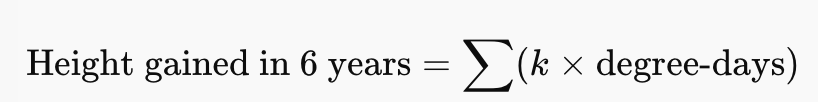


So when you increase the target from 1.5 → 2.0 m, you are asking for:

+33% more height

within the same fixed 6-year window

That is a huge constraint.

If trees just barely reach 1.5 m in many windows, then:

they fail completely at 2.0 m

success probability drops to near zero

In [ ]:
WINDOWS = [6, 8, 10]  # longer rotations for larger trees (more realistic)
TARGET_HEIGHTS = {"Market: 1.5m": 1.5, "Market: 2.0m": 2.0}

rows = []
for ssp_name, raw in ssp_sources.items():
    annual = annual_indicators_from_remapped(raw)

    for market_name, target_h in TARGET_HEIGHTS.items():
        for scen_name, k_mult in SCENARIOS.items():
            for w in WINDOWS:
                p = six_year_success_for_target(
                    annual,
                    k_value=k * k_mult,
                    target_height=target_h,
                    window_years=w
                )
                years_100 = expected_years_for_100(p, window_years=w)

                rows.append({
                    "ssp": ssp_name,
                    "market_target": market_name,
                    "target_height_m": target_h,
                    "scenario": scen_name,
                    "k_multiplier": k_mult,
                    "window_years": w,
                    "p_reach_target_in_window": p,
                    "expected_years_to_get_100": years_100
                })

policy_market_window = pd.DataFrame(rows)
policy_market_window


,ssp,market_target,target_height_m,scenario,k_multiplier,window_years,p_reach_target_in_window,expected_years_to_get_100
0,SSP126,Market: 1.5m,1.5,Baseline,1.00,6,0.506173,12.0
1,SSP126,Market: 1.5m,1.5,Baseline,1.00,8,1.000000,8.0
2,SSP126,Market: 1.5m,1.5,Baseline,1.00,10,1.000000,10.0
3,SSP126,Market: 1.5m,1.5,Improved management,1.15,6,0.987654,12.0
4,SSP126,Market: 1.5m,1.5,Improved management,1.15,8,1.000000,8.0
5,SSP126,Market: 1.5m,1.5,Improved management,1.15,10,1.000000,10.0
6,SSP126,Market: 2.0m,2.0,Baseline,1.00,6,0.000000,inf
7,SSP126,Market: 2.0m,2.0,Baseline,1.00,8,0.506329,16.0
8,SSP126,Market: 2.0m,2.0,Baseline,1.00,10,1.000000,10.0
9,SSP126,Market: 2.0m,2.0,Improved management,1.15,6,0.000000,inf


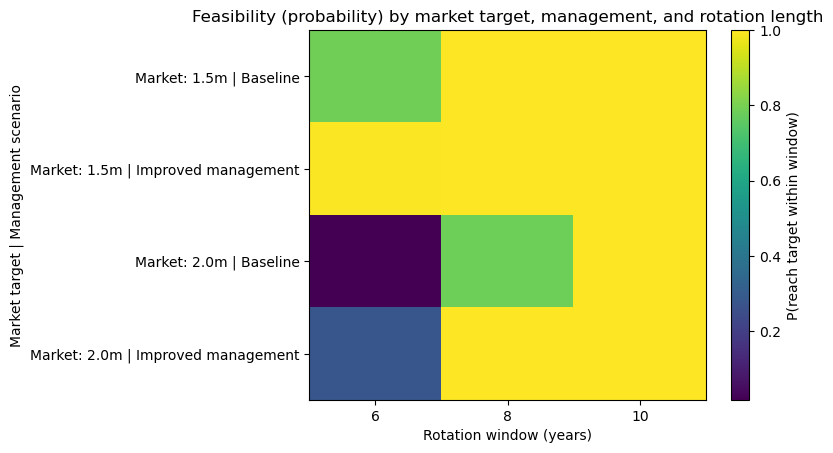

In [ ]:
# Make a pivot for probability
piv_p = policy_market_window.pivot_table(
    index=["market_target","scenario"],
    columns="window_years",
    values="p_reach_target_in_window",
    aggfunc="mean"
).sort_index()

plt.figure()
plt.imshow(piv_p.values, aspect="auto")
plt.colorbar(label="P(reach target within window)")
plt.yticks(range(len(piv_p.index)), [f"{i[0]} | {i[1]}" for i in piv_p.index])
plt.xticks(range(len(piv_p.columns)), piv_p.columns)
plt.title("Feasibility (probability) by market target, management, and rotation length")
plt.xlabel("Rotation window (years)")
plt.ylabel("Market target | Management scenario")
plt.show()


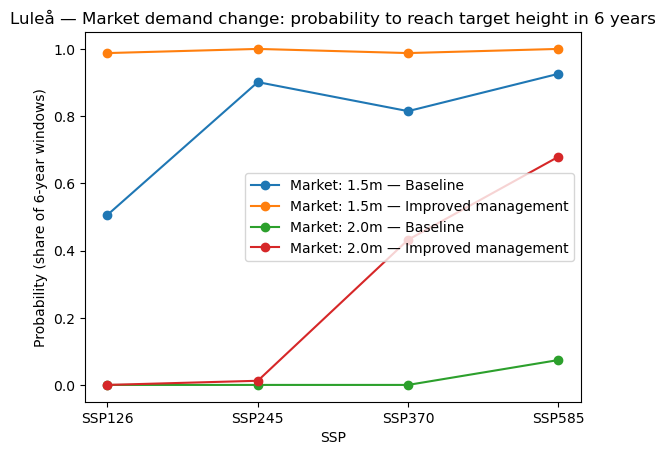

In [ ]:
plt.figure()
for (market, scen), grp in policy_market.groupby(["market_target", "scenario"]):
    plt.plot(grp["ssp"], grp["p_reach_target_in_6y"], marker="o", label=f"{market} — {scen}")

plt.title("Luleå — Market demand change: probability to reach target height in 6 years")
plt.xlabel("SSP")
plt.ylabel("Probability (share of 6-year windows)")
plt.legend()
plt.show()


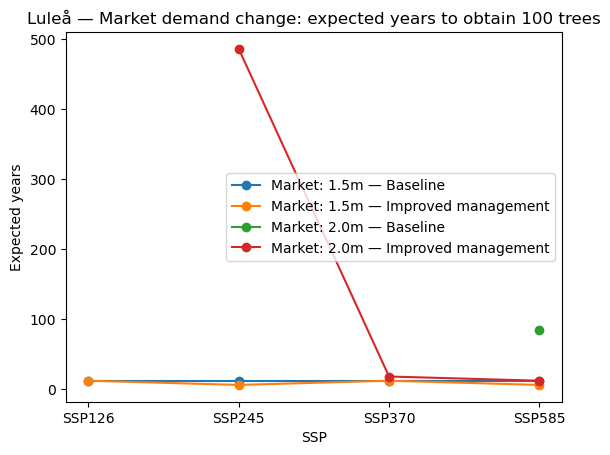

In [ ]:
plt.figure()
for (market, scen), grp in policy_market.groupby(["market_target", "scenario"]):
    plt.plot(grp["ssp"], grp["expected_years_to_get_100"], marker="o", label=f"{market} — {scen}")

plt.title("Luleå — Market demand change: expected years to obtain 100 trees")
plt.xlabel("SSP")
plt.ylabel("Expected years")
plt.legend()
plt.show()


### Loading other SSP files for Scenario uncertainty

raw126 = pd.read_csv("ssp126.csv")
raw370 = pd.read_csv("ssp370.csv")
raw585 = pd.read_csv("ssp585.csv")

## Scenario uncertainty across SSPs (same model, different climate forcing)


In [ ]:
# --- Scenario uncertainty across SSPs (same model, different climate forcing) ---

def annual_indicators_from_remapped(raw_df, base_temp=BASE_TEMP, days_per_step=DAYS_PER_STEP):
    df = filter_location(raw_df).copy()
    df = add_week_time(df)
    df = to_celsius_if_needed(df, "Temp")
    df["year"] = df["time"].dt.year

    df["dd_week"] = np.maximum(df["temp_c"] - base_temp, 0.0) * days_per_step
    df["growing_week"] = (df["temp_c"] > base_temp).astype(int)

    annual = df.groupby("year", as_index=False).agg(
        tmean=("temp_c", "mean"),
        dd_sum=("dd_week", "sum"),
        growing_weeks=("growing_week", "sum"),
    )

    annual = annual[annual["dd_sum"] > 0].copy()  # avoid partial/zero years
    annual["decade"] = (annual["year"] // 10) * 10
    return annual

def add_tth_from_k(annual, k_value):
    out = annual.copy()
    out["annual_growth_m_per_yr"] = np.maximum(k_value * out["dd_sum"], 1e-9)
    out["tth_years"] = TARGET_HEIGHT / out["annual_growth_m_per_yr"]
    return out

ssps = {
    "SSP126": raw126,
    "SSP245": raw245,
    "SSP370": raw370,
    "SSP585": raw585,
}

annual_by_ssp = {name: annual_indicators_from_remapped(df) for name, df in ssps.items()}
tth_by_ssp = {name: add_tth_from_k(annual, k) for name, annual in annual_by_ssp.items()}

# quick sanity check
{k: (int(v["year"].min()), int(v["year"].max())) for k, v in tth_by_ssp.items()}


{'SSP126': (2015, 2100),
 'SSP245': (2015, 2100),
 'SSP370': (2015, 2100),
 'SSP585': (2015, 2100)}

In [ ]:
decadal_ssp = []
for ssp, df in tth_by_ssp.items():
    d = df.groupby("decade")["tth_years"].agg(
        median="median",
        p10=lambda x: np.quantile(x, 0.10),
        p90=lambda x: np.quantile(x, 0.90),
    ).reset_index()
    d["ssp"] = ssp
    decadal_ssp.append(d)

decadal_ssp = pd.concat(decadal_ssp, ignore_index=True)

# Scenario spread per decade (how different SSPs are from each other)
spread = decadal_ssp.pivot(index="decade", columns="ssp", values="median").reset_index()
spread["scenario_range"] = spread[[c for c in spread.columns if c.startswith("SSP")]].max(axis=1) - \
                           spread[[c for c in spread.columns if c.startswith("SSP")]].min(axis=1)

spread


ssp,decade,SSP126,SSP245,SSP370,SSP585,scenario_range
0,2010,5.994300,5.994300,5.994300,5.994300,0.000000
1,2020,6.040452,6.044066,6.323917,5.954651,0.369266
2,2030,5.951455,6.066238,6.119892,5.763612,0.356280
3,2040,5.473532,5.772151,5.754650,4.972016,0.800135
4,2050,5.953072,5.343467,5.440502,5.141304,0.811768
5,2060,5.651669,5.729484,5.127842,5.016134,0.713351
6,2070,6.196280,5.258663,5.066202,4.731135,1.465145
7,2080,6.404544,5.334049,4.863929,4.877671,1.540616
8,2090,6.500110,5.492861,4.953400,4.628291,1.871819
9,2100,7.193683,5.075866,4.336016,4.743266,2.857667


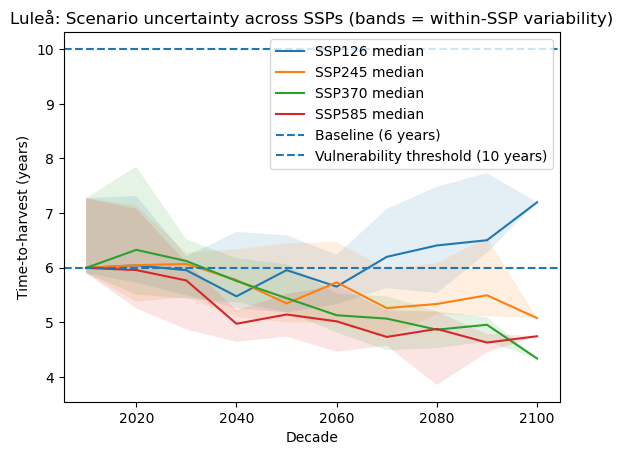

In [ ]:
plt.figure()

for ssp in ["SSP126", "SSP245", "SSP370", "SSP585"]:
    sub = decadal_ssp[decadal_ssp["ssp"] == ssp].sort_values("decade")
    plt.plot(sub["decade"], sub["median"], label=f"{ssp} median")
    plt.fill_between(sub["decade"], sub["p10"], sub["p90"], alpha=0.12)

plt.axhline(BASELINE_YEARS, linestyle="--", label="Baseline (6 years)")
plt.axhline(10.0, linestyle="--", label="Vulnerability threshold (10 years)")

plt.xlabel("Decade")
plt.ylabel("Time-to-harvest (years)")
plt.title("Luleå: Scenario uncertainty across SSPs (bands = within-SSP variability)")
plt.legend()
plt.show()


------------IGNORE BELOW----------------

In [ ]:
print("temp_c stats:", l245["temp_c"].describe())
print("dd_week stats:", l245["dd_week"].describe())

# How many weeks are above BASE_TEMP?
print("Weeks above BASE_TEMP:", int((l245["temp_c"] > BASE_TEMP).sum()), "out of", len(l245))

# Check annual dd_sum distribution
print(annual_ind[["year","dd_sum","growing_weeks"]].head(10))
print(annual_ind[["dd_sum","growing_weeks"]].describe())


temp_c stats: count    4558.000000
mean        2.974556
std         9.830413
min       -33.338614
25%        -4.556457
50%         2.338279
75%        11.966775
max        22.728429
Name: temp_c, dtype: float64
dd_week stats: count    4558.000000
mean       23.025346
std        31.830363
min         0.000000
25%         0.000000
50%         0.000000
75%        48.767425
max       124.099000
Name: dd_week, dtype: float64
Weeks above BASE_TEMP: 2003 out of 4558
    year     dd_sum  growing_weeks
1   2015  1019.7075             23
2   2016  1153.8100             22
3   2017  1161.3551             21
4   2018   910.4948             20
5   2019  1180.7754             24
6   2020   882.5822             22
7   2021  1152.7139             23
8   2022   979.5840             22
9   2023  1011.0143             21
10  2024  1136.0270             25
            dd_sum  growing_weeks
count    86.000000      86.000000
mean   1220.343359      23.290698
std     133.345946       1.651141
min     882.582

In [ ]:
# Pick a calibration period that exists in dataset
min_year = int(annual_ind["year"].min())
max_year = int(annual_ind["year"].max())

# Use first 15 years 
ref_start = min_year
ref_end = min(min_year + 14, max_year)

print("Available years:", min_year, "→", max_year)
print("Using calibration period:", ref_start, "→", ref_end)

def calibrate_k_auto(annual_ind, baseline_years=6.0, ref_start=ref_start, ref_end=ref_end):
    ref = annual_ind[(annual_ind["year"] >= ref_start) & (annual_ind["year"] <= ref_end)].dropna(subset=["dd_sum"])
    if ref.empty:
        raise ValueError("No rows in chosen calibration period.")
    dd_ref = float(np.median(ref["dd_sum"].values))
    if dd_ref <= 0:
        raise ValueError(f"Calibration dd_sum median is {dd_ref}. Try lowering BASE_TEMP or check dd_sum.")
    k = TARGET_HEIGHT / (baseline_years * dd_ref)
    return k, dd_ref

k, dd_ref = calibrate_k_auto(annual_ind, baseline_years=BASELINE_YEARS, ref_start=ref_start, ref_end=ref_end)
print("Calibrated k:", k)
print("Median dd_sum in calibration period:", dd_ref)


Available years: 2014 → 2101
Using calibration period: 2014 → 2028
Calibrated k: 0.0015404563447875797
Median dd_sum in calibration period: 162.28957142857143
